21.302840249280454
0.014223746955394745
0.50170255 1.0 0.08527506239167694
3.1048429697771565


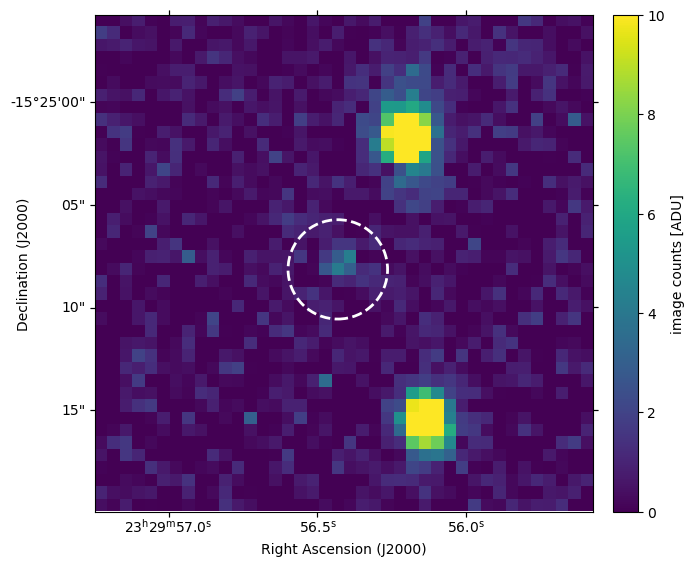

In [114]:
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from astropy.modeling.models import Gaussian2D
from astropy.io import fits
from astropy.wcs import WCS

from astropy.nddata import Cutout2D
from astropy import units as u


import matplotlib.patheffects as pe
from matplotlib.patches import Circle, Ellipse
from matplotlib.patheffects import withStroke




with fits.open('/utils/J2329-1520_nirJ_coadd.fits') as hdul:  #online-github repo contains J2329-1520_nirJ_coadd.fits as an example
    #hdul.info()
    data=hdul[0].data
    header = hdul[0].header
    wcs = WCS(header)
    #print(repr(header))
# FITS file opening
    
shift_x = 20 
shift_y = -20

shifted_data = np.roll(data, (shift_x, shift_y), axis=(0,1))

header['CRPIX1'] -= shift_x
header['CRPIX2'] -= shift_y
wcs = WCS(header)

hdu = fits.PrimaryHDU(shifted_data, header=header)


#hdu.writeto('/utils/.../shifted_coadd_{}_{}.fits'.format(shift_x, shift_y))

# SHIFTING FITS files for 'dithering'/forced photometry for SExtractor



#bckgrnd_mag=(23.0189, 24.1999, 25.8409, 24.2089, 24.2089, 24.2258, 24.4539)

bckgrnd_flux_J0244=(1.731534, 1.6020, 0.2795304, -0.9128518, -1.325227, 1.2373, -0.9128518, 1.002844)
bckgrnd_flux_J2329_old=(-11.54761, 0.74694, 7.762591, 2.502056, 21.203, 6.697908, -9.305124, 17.07501)

bckgrnd_flux_J2329=(0.74694, 2.502056, 6.697908, 3.529449, 7.762591, 4.20875, -3.776793, -11.54761)

Bf_mean=np.mean(bckgrnd_flux_J2329)
Bf_std=np.std(bckgrnd_flux_J2329)

#ZP_J0244=24.457
#MAGf_J0244=72.5603

ZP_J2329=24.457
MAGf_J2329=52.26686
#MAGf_J2329=18.26686


#print('mean[Flux space]: {}+-{}'.format(Bf_mean, Bf_std))

mag_std_low=-2.5*math.log10(MAGf_J2329+Bf_std)+2.5*math.log10(MAGf_J2329)
mag_std_up=-2.5*math.log10(MAGf_J2329-Bf_std)+2.5*math.log10(MAGf_J2329)
mag=-2.5*math.log10(MAGf_J2329)+ZP_J2329

def signaltonoise(a, axis=None, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)



fig=plt.figure(figsize=(7,6.45))
ax = plt.subplot(projection=wcs, frameon=False) #figsize=(7,7) works in subplotS<---

aperture_rad = 4
position = (508, 485)
size = 40
pixsize = size * u.pixel
cutout = Cutout2D(data, position, pixsize)

from matplotlib.colors import PowerNorm

plt.xlabel('Right Ascension (J2000)')
plt.ylabel('Declination (J2000)', labelpad=-1)

im = ax.imshow(cutout.data, origin='lower', aspect = 'auto', cmap='viridis', vmin=0, vmax=10)
ax.add_artist(Circle((size/2-1,size/2-1), radius=aperture_rad, clip_on=False, linewidth=2, ls = '--', edgecolor= 'white', facecolor='none'))

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
import matplotlib.axes as maxes
cax = divider.append_axes("right", size="5%", pad=0.2, axes_class=maxes.Axes)
cbar = fig.colorbar(im, cax=cax, label='image counts [ADU]')


plt.axis('off')
plt.show()

In [9]:
import os
import pandas as pd
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import re

# === SETTINGS ===
photometry_file = "/utils/photometry_matches.txt"
fits_folder = "/utils/fits_folder"
output_folder = os.path.join(fits_folder, "postage_stamps")
cutout_size = 20  # size in pixels

os.makedirs(output_folder, exist_ok=True)

# Load photometry table
df = pd.read_csv(photometry_file, delimiter="\t")

# Extract base name from Filename column
df["Base"] = df["Filename"].str.extract(r"(J\d{4}[+-]\d{4}(?:\(dup\))?)")
df["Aperture"] = df["Aperture"].astype(float)

print(f"Processing {len(df)} objects...")

for _, row in df.iterrows():
    filename = row["Filename"]
    x = row["X_IMAGE"]
    y = row["Y_IMAGE"]

    if pd.isna(x) or pd.isna(y):
        print(f"Skipping {filename}: missing X/Y_IMAGE")
        continue

    base = row["Base"]
    aperture = row["Aperture"]
    radius = aperture / 2.0

    # Extract aperture tag (e.g., "3p4") from filename
    match = re.search(r"_ap([0-9p]+)", filename)
    if not match:
        print(f"Skipping {filename}: could not parse aperture tag")
        continue
    aper_tag = match.group(1)

    fits_path = os.path.join(fits_folder, f"{base}.fits")
    if not os.path.isfile(fits_path):
        print(f"Missing FITS file: {fits_path}")
        continue

    with fits.open(fits_path) as hdul:
        data = hdul[0].data

    x0 = float(x) - 1          # 0-based catalogue coordinate
    y0 = float(y) - 1

    half = cutout_size // 2
    xc  = int(round(x0))       # nearest integer pixel index (0-based)
    yc  = int(round(y0))

    x_min = xc - half
    x_max = x_min + cutout_size
    y_min = yc - half
    y_max = y_min + cutout_size


    if x_min < 0 or y_min < 0 or x_max > data.shape[1] or y_max > data.shape[0]:
        print(f"Skipping {filename}: cutout out of bounds")
        continue

    cutout = data[y_min:y_max, x_min:x_max]

    fig, ax = plt.subplots()
    im = ax.imshow(cutout, cmap='viridis', origin='lower')
    ax.set_xticks([])
    ax.set_yticks([])

    x_cutout = x0 - x_min      # fractional offset of the star
    y_cutout = y0 - y_min


    circle = patches.Circle((x_cutout, y_cutout), radius=radius,
                            edgecolor='white', facecolor='none', lw=1.5)
    ax.add_patch(circle)

    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=8)

    output_path = os.path.join(output_folder, f"{base}_ap{aper_tag}_cutout_{int(cutout_size)}.png")
    plt.savefig(output_path, bbox_inches='tight', dpi=150)
    plt.close(fig)

    print(f"Saved cutout: {output_path}")

Processing 74 objects...
Saved cutout: /home/jk/Desktop/reduced1/onlyfits/postage_stamps/J0033-0125_ap5p0_cutout_20.png
Saved cutout: /home/jk/Desktop/reduced1/onlyfits/postage_stamps/J0033-0125_ap7p0_cutout_20.png
Saved cutout: /home/jk/Desktop/reduced1/onlyfits/postage_stamps/J0046-2837_ap5p0_cutout_20.png
Saved cutout: /home/jk/Desktop/reduced1/onlyfits/postage_stamps/J0046-2837_ap7p0_cutout_20.png
Saved cutout: /home/jk/Desktop/reduced1/onlyfits/postage_stamps/J0142-3327_ap5p0_cutout_20.png
Saved cutout: /home/jk/Desktop/reduced1/onlyfits/postage_stamps/J0142-3327_ap7p0_cutout_20.png
Saved cutout: /home/jk/Desktop/reduced1/onlyfits/postage_stamps/J0159-3633_ap5p0_cutout_20.png
Saved cutout: /home/jk/Desktop/reduced1/onlyfits/postage_stamps/J0159-3633_ap7p0_cutout_20.png
Saved cutout: /home/jk/Desktop/reduced1/onlyfits/postage_stamps/J0213-0626_ap5p0_cutout_20.png
Saved cutout: /home/jk/Desktop/reduced1/onlyfits/postage_stamps/J0213-0626_ap7p0_cutout_20.png
Saved cutout: /home/jk/De

In [2]:
import os
import pandas as pd
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import re

# === SETTINGS ===
photometry_file = "/utils/photometry_matches.txt"
fits_folder = "/utils/fits_folder"
output_folder = os.path.join(fits_folder, "postage_stamps_small")
cutout_size = 10  # size in pixels

os.makedirs(output_folder, exist_ok=True)

# Load photometry table
df = pd.read_csv(photometry_file, delimiter="\t")

# Extract base name from Filename column
df["Base"] = df["Filename"].str.extract(r"(J\d{4}[+-]\d{4}(?:\(dup\))?)")
df["Aperture"] = df["Aperture"].astype(float)

print(f"Processing {len(df)} objects...")

for _, row in df.iterrows():
    filename = row["Filename"]
    x = row["X_IMAGE"]
    y = row["Y_IMAGE"]

    if pd.isna(x) or pd.isna(y):
        print(f"Skipping {filename}: missing X/Y_IMAGE")
        continue

    base = row["Base"]
    aperture = row["Aperture"]
    radius = aperture / 2.0

    # Extract aperture tag (e.g., "3p4") from filename
    match = re.search(r"_ap([0-9p]+)", filename)
    if not match:
        print(f"Skipping {filename}: could not parse aperture tag")
        continue
    aper_tag = match.group(1)

    fits_path = os.path.join(fits_folder, f"{base}.fits")
    if not os.path.isfile(fits_path):
        print(f"Missing FITS file: {fits_path}")
        continue

    with fits.open(fits_path) as hdul:
        data = hdul[0].data

    x = float(x)
    y = float(y)

    half = cutout_size // 2
    x_min = int(round(x)) - half
    x_max = x_min + cutout_size
    y_min = int(round(y)) - half
    y_max = y_min + cutout_size

    if x_min < 0 or y_min < 0 or x_max > data.shape[1] or y_max > data.shape[0]:
        print(f"Skipping {filename}: cutout out of bounds")
        continue

    cutout = data[y_min:y_max, x_min:x_max]

    fig, ax = plt.subplots()
    im = ax.imshow(cutout, cmap='viridis', origin='lower')
    ax.set_xticks([])
    ax.set_yticks([])

    x_cutout = x - 1 - x_min
    y_cutout = y - 1 - y_min

    circle = patches.Circle((x_cutout, y_cutout), radius=radius,
                            edgecolor='white', facecolor='none', lw=1.5)
    ax.add_patch(circle)


    ax.set_title(base, fontsize=20)

    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=18)
    cbar.set_label("Pixel value", fontsize=18)

    output_path = os.path.join(output_folder, f"{base}_ap{aper_tag}_special.png")
    plt.savefig(output_path, bbox_inches='tight', dpi=150)
    plt.close(fig)

    print(f"Saved cutout: {output_path}")

Processing 74 objects...
Saved cutout: /home/jk/Desktop/reduced1/onlyfits/postage_idiots/J0033-0125_ap5p0_special.png
Saved cutout: /home/jk/Desktop/reduced1/onlyfits/postage_idiots/J0033-0125_ap7p0_special.png
Saved cutout: /home/jk/Desktop/reduced1/onlyfits/postage_idiots/J0046-2837_ap5p0_special.png
Saved cutout: /home/jk/Desktop/reduced1/onlyfits/postage_idiots/J0046-2837_ap7p0_special.png
Saved cutout: /home/jk/Desktop/reduced1/onlyfits/postage_idiots/J0142-3327_ap5p0_special.png
Saved cutout: /home/jk/Desktop/reduced1/onlyfits/postage_idiots/J0142-3327_ap7p0_special.png
Saved cutout: /home/jk/Desktop/reduced1/onlyfits/postage_idiots/J0159-3633_ap5p0_special.png
Saved cutout: /home/jk/Desktop/reduced1/onlyfits/postage_idiots/J0159-3633_ap7p0_special.png
Saved cutout: /home/jk/Desktop/reduced1/onlyfits/postage_idiots/J0213-0626_ap5p0_special.png
Saved cutout: /home/jk/Desktop/reduced1/onlyfits/postage_idiots/J0213-0626_ap7p0_special.png
Saved cutout: /home/jk/Desktop/reduced1/onlyf

In [22]:
import os, re
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from astropy.io import fits
from astropy.wcs import WCS
from astropy.nddata import Cutout2D

# ========== SETTINGS ==========
FITS_FOLDER   = "/utils/fits_folder/nondetect/"
CATALOG_CSV   = "/utils/aa61_fan_qso_database.csv"  #not included in the online-repo, because it is courtesy of the 2020 Fan review paper
OUTPUT_SUBDIR = "nondetect_cutouts"
CUTOUT_SIZE   = 10           # pixels (square)
APER_DIAM     = 5            # pixels
NAME_COL_RAW  = ("Quasar", "Unnamed: 0_level_1")
RA_COL_RAW    = ("ra", "J2000 (deg)")
DEC_COL_RAW   = ("dec", "J2000 (deg)")
# ==============================

# ---------- utilities ----------
def short_name(long_name):
    """
    Convert full coordinate name like
    'J005502.92+014617.80' → 'J0055+0146'
    """
    match = re.match(r"(J\d{4})\d*\.\d*([+-]\d{4})\d*\.\d*", str(long_name))
    if match:
        ra_short = match.group(1)  # e.g. J0055
        dec_short = match.group(2)  # e.g. +0146 or -1121
        return ra_short + dec_short
    else:
        return None

# ---------- prepare output ----------
OUT_DIR = os.path.join(FITS_FOLDER, OUTPUT_SUBDIR)
os.makedirs(OUT_DIR, exist_ok=True)

# ---------- read and flatten catalog ----------
print("Reading catalog …")
df = pd.read_csv(CATALOG_CSV, header=[0, 1])          # two-row header

# flatten MultiIndex columns → 'Quasar', 'ra', 'dec'
df.columns = [
    col[0] if col[1].startswith("Unnamed") else f"{col[0]}_{col[1]}"
    for col in df.columns.to_list()
]

NAME_COL = "Quasar"
RA_COL   = "ra_J2000 (deg)"
DEC_COL  = "dec_J2000 (deg)"

df["ShortName"] = df[NAME_COL].apply(short_name)

catalog = {
    row["ShortName"]: (row[RA_COL], row[DEC_COL])
    for _, row in df.iterrows()
    if pd.notna(row["ShortName"])
}

print(f"Catalog indexed: {len(catalog)} objects.\n")

# ---------- iterate FITS files ----------
for fname in sorted(f for f in os.listdir(FITS_FOLDER) if f.lower().endswith(".fits")):
    short = os.path.splitext(fname)[0]   # Jhhhh±dddd

    if short not in catalog:
        print(f"{fname}: no catalog match → skipped")
        continue

    ra_deg, dec_deg = catalog[short]
    fits_path       = os.path.join(FITS_FOLDER, fname)

    with fits.open(fits_path) as hdul:
        data, header = hdul[0].data, hdul[0].header
        wcs          = WCS(header)

    try:
        from astropy.coordinates import SkyCoord
        import astropy.units as u

        # Convert RA/DEC (deg) to pixel coordinates
        sky_coord = SkyCoord(ra=ra_deg*u.deg, dec=dec_deg*u.deg)
        pix_coord = wcs.world_to_pixel(sky_coord)

        cut = Cutout2D(data, pix_coord, CUTOUT_SIZE, wcs=wcs, mode='trim')
    except Exception as e:
        print(f"{fname}: Cutout2D failed ({e})")
        continue

    # ---------- plot ----------
    fig, ax = plt.subplots(figsize=(4, 4), subplot_kw={'projection': cut.wcs})
    im = ax.imshow(cut.data, origin="lower", cmap="viridis")
    ax.set_xticks([]); ax.set_yticks([])

    circ = patches.Circle((CUTOUT_SIZE/2, CUTOUT_SIZE/2),
                          radius=APER_DIAM/2,
                          transform=ax.get_transform('pixel'),
                          edgecolor="white", facecolor="none", lw=1.5)
    ax.add_patch(circ)

    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=8)

    out_png = os.path.join(OUT_DIR, f"{short}_cutout.png")
    plt.savefig(out_png, dpi=150, bbox_inches="tight", pad_inches=0.05)
    plt.close(fig)
    print(f"{fname}: saved {out_png}")

print("\nDone.")

Reading catalog …
Catalog indexed: 530 objects.



J0055+0146.fits: saved /home/jk/Desktop/reduced1/onlyfits/nondetect/nondetect_cutouts/J0055+0146_cutout.png


J0929-1121.fits: saved /home/jk/Desktop/reduced1/onlyfits/nondetect/nondetect_cutouts/J0929-1121_cutout.png


J1350-0027.fits: saved /home/jk/Desktop/reduced1/onlyfits/nondetect/nondetect_cutouts/J1350-0027_cutout.png


J1357-0843.fits: saved /home/jk/Desktop/reduced1/onlyfits/nondetect/nondetect_cutouts/J1357-0843_cutout.png


J2227-3323.fits: saved /home/jk/Desktop/reduced1/onlyfits/nondetect/nondetect_cutouts/J2227-3323_cutout.png

Done.


[('Quasar', 'Unnamed: 0_level_1'), ('ra', 'J2000 (deg)'), ('dec', 'J2000 (deg)'), ('redshift', 'Unnamed: 3_level_1'), ('redshift_reference', 'Unnamed: 4_level_1'), ('m1450', 'AB mag'), ('Mabs1450', 'AB mag'), ('redshift_mgii', 'Unnamed: 7_level_1'), ('redshift_mgii_err', 'Unnamed: 8_level_1'), ('redshift_mgii_ref', 'Unnamed: 9_level_1'), ('fwhm_mgii', 'km/s'), ('fwhm_mgii_err_up', 'km/s'), ('fwhm_mgii_err_low', 'km/s'), ('L3000', '1e46 reg/s'), ('L3000err_up', '1e46 reg/s'), ('L3000err_low', '1e46 erg/s'), ('BHmass', '1e8 M_sun'), ('BHmass_reference', 'Unnamed: 17_level_1')]
